In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
import pickle
import random
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from functions import *
#from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from sklearn.externals import joblib

In [2]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        w = bbox[1][0] - bbox[0][0]
        h = bbox[1][1] - bbox[0][1]
        a = w*h
        #print(a)
        if a > 3000:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)
    # Return the image
    return img

8792
8968


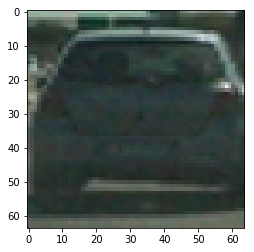

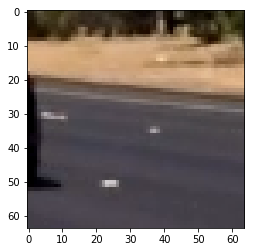

In [3]:
# Divide up into cars and notcars
car_images = glob.glob('vehicles/*/*.png')
not_car_images = glob.glob('non-vehicles/*/*.png')
cars = []
notcars = []
for img in car_images:
    cars.append(img)
for img in not_car_images:
    notcars.append(img)

print(len(cars))
print(len(notcars))
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 8500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]
cars = random.sample(cars,len(cars))
notcars = random.sample(notcars,len(notcars))
plt.imshow(mpimg.imread(cars[5]))
plt.show()
plt.imshow(mpimg.imread(notcars[5]))
plt.show()

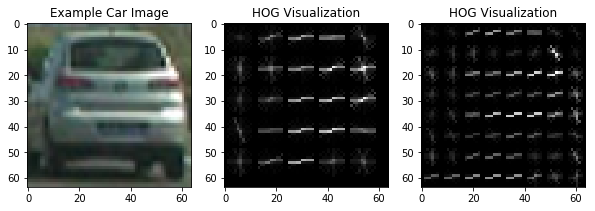

In [4]:
image = mpimg.imread(cars[15])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, hog_image1 = get_hog_features(gray, orient= 11, 
                        pix_per_cell= 12, cell_per_block= 2, 
                        vis=True, feature_vec=False)
features, hog_image2 = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

fig = plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(hog_image1, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(133)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization')
plt.show()

In [5]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 12 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [6]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler()
# Apply the scaler to X
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

#parameters = {'kernel':('linear', 'rbf'), 'C':[0.001,0.01]}
clf = svm.SVC(kernel='rbf',C=10)
#clf = GridSearchCV(svr, parameters)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 4896
185.66 Seconds to train SVC...
Test Accuracy of SVC =  0.995


In [20]:
joblib.dump(clf,'predict1.pkl') 

['predict1.pkl']

In [7]:
print(clf.decision_function(X_test))
# Test stacking
a = np.empty((0,2,2), int)
b = np.array([[[1,2],[3,4]]])
c = np.vstack((a,b))
c = np.vstack((c,b))
print(a.shape)
print(b.shape)
print(c.shape)
print(c)

[-2.59213411 -0.70666531 -1.18386946 ...,  1.82921612 -3.17220798
  1.69148808]
(0, 2, 2)
(1, 2, 2)
(2, 2, 2)
[[[1 2]
  [3 4]]

 [[1 2]
  [3 4]]]


In [8]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = np.copy(img_tosearch)
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = np.empty((0,2,2), int)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((hist_features,hog_features)).reshape(1, -1)) 
            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            desc = svc.decision_function(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = np.array([[[xbox_left, ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]]])
                #print(boxes.shape)
                #print(box.shape)
                boxes = np.vstack((boxes,box))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    #print(boxes)    
    return boxes,draw_img

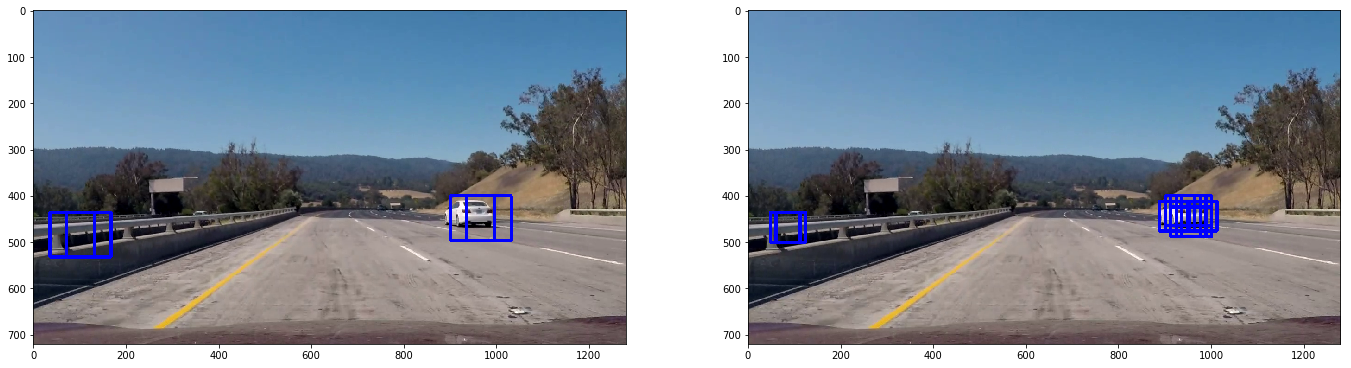

In [9]:
clf = joblib.load('predict1.pkl')
image = mpimg.imread('test_images/test13.jpg')
# scale2 = 2.0
# ystart2 = 360
# ystop2 = 650
# box2,img2 = find_cars(image, ystart2, ystop2, scale2, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
scale3 = 1.5
ystart3 = 400
ystop3 = 540
cells_per_step = 2
box3,img3 = find_cars(image, ystart3, ystop3, scale3, clf, X_scaler, orient, pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins)
scale4 = 1.0
ystart4 = 400
ystop4 = 500
cells_per_step = 1
box4,img4 = find_cars(image, ystart4, ystop4, scale4, clf, X_scaler, orient, pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins)
boxes = np.concatenate((box3,box4))

fig = plt.figure(figsize=(20,10))
# plt.subplot(221)
# plt.imshow(img2)
plt.subplot(221)
plt.imshow(img3)
plt.subplot(222)
plt.imshow(img4)
# plt.subplot(224)
# plt.imshow(img4)
fig.tight_layout()
plt.show()

In [10]:
print(boxes.shape)
print(box3)

(19, 2, 2)
[[[  36  436]
  [ 132  532]]

 [[  72  436]
  [ 168  532]]

 [[ 900  400]
  [ 996  496]]

 [[ 936  400]
  [1032  496]]]


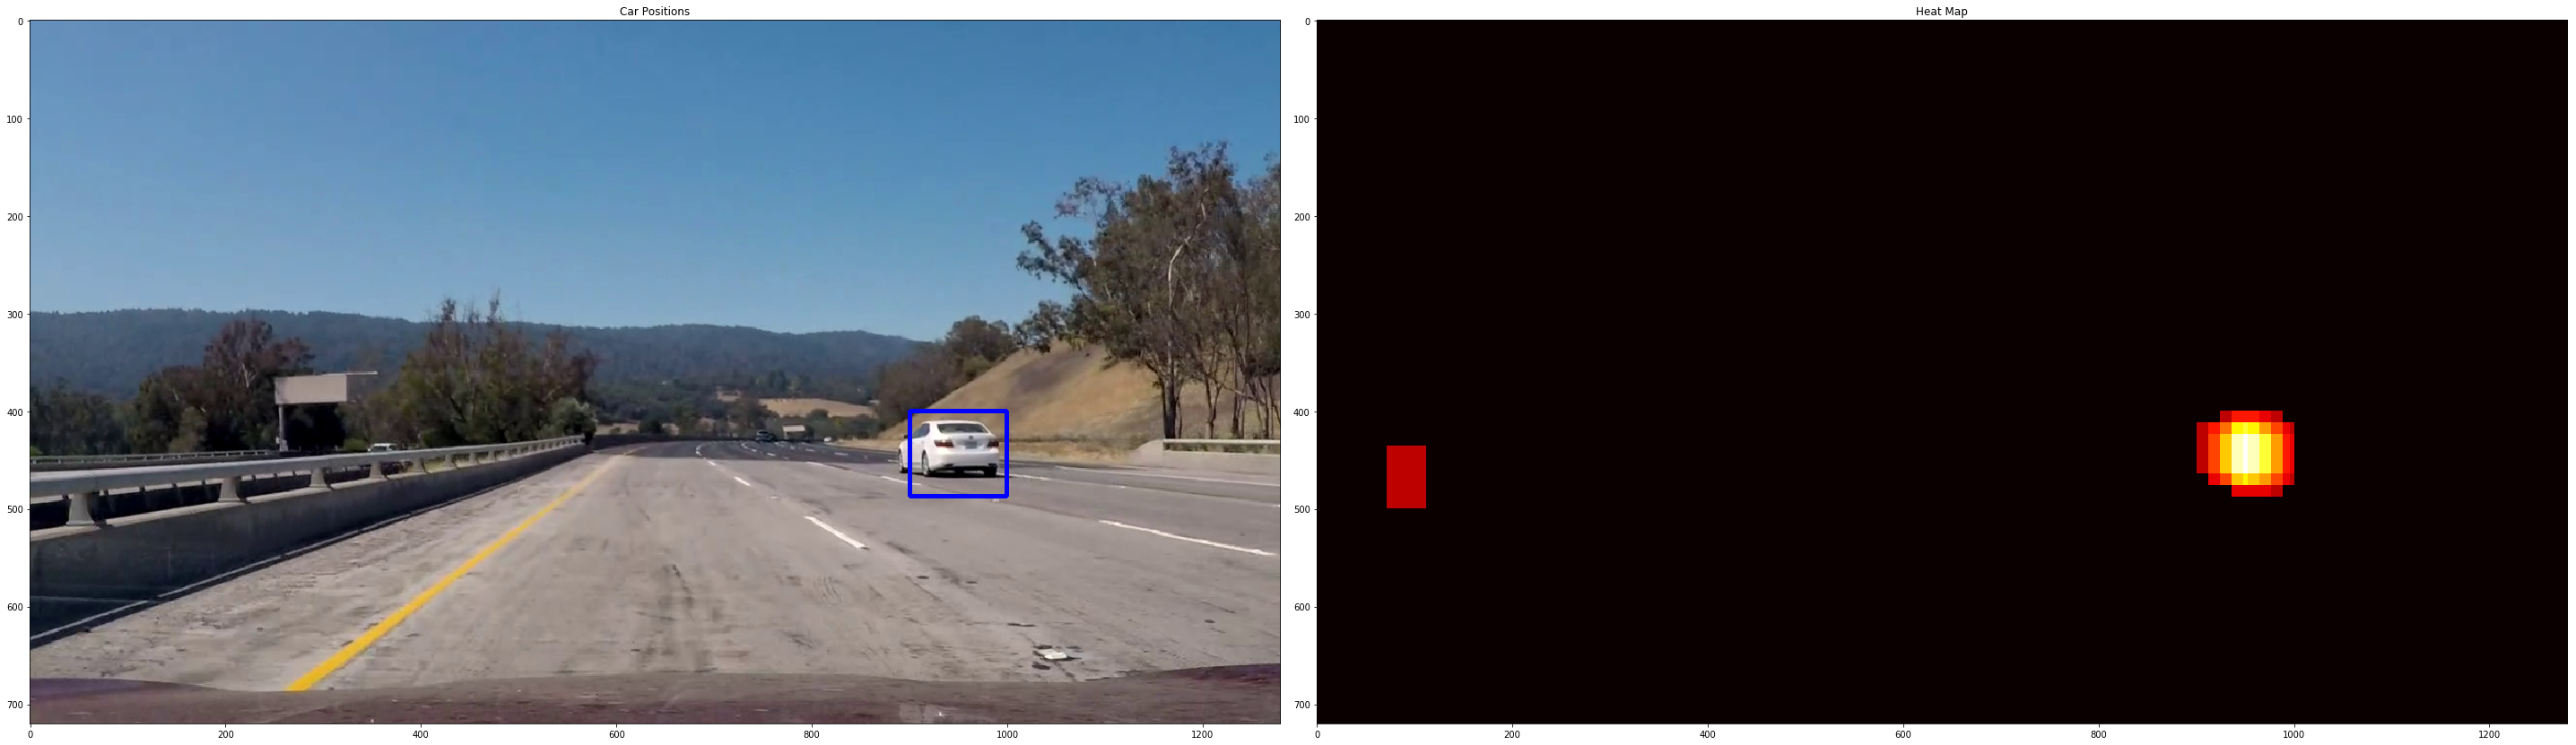

In [11]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)


fig = plt.figure(figsize=(40,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

In [12]:
def process_image(frame):
    global count
    global labels
    if count < 5:
        scale1 = 1.5
        ystart1 = 400
        ystop1 = 540
        box1,img1 = find_cars(frame, ystart1, ystop1, scale1, clf, X_scaler, orient, pix_per_cell, cell_per_block, cells_per_step, spatial_size, hist_bins)

        scale2 = 1.0
        ystart2 = 400
        ystop2 = 480
        box2,img2 = find_cars(frame, ystart2, ystop2, scale2, clf, X_scaler, orient, pix_per_cell, cell_per_block, cells_per_step, spatial_size, hist_bins)
        box = np.concatenate((box1,box2))
        boxes.append(box)
        heat = np.zeros_like(frame[:,:,0]).astype(np.float)
        for b in boxes:
            heat = add_heat(heat,b)
        thresh = len(boxes)*3.2
        heat = apply_threshold(heat,thresh)  
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        result = draw_labeled_bboxes(np.copy(frame), labels)
        count = count +1
        return result
    if count>=5 and count<10:
        result = draw_labeled_bboxes(np.copy(frame), labels)
        if count == 9:
            count=0
            return result
        else:
            count = count +1
            return result

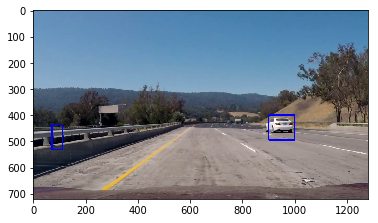

In [13]:
from collections import deque
boxes = deque(maxlen = 5)
count = 0
image = mpimg.imread('test_images/test13.jpg')
result = process_image(image)
#print(boxes)
plt.imshow(result)
plt.show()

In [14]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
count = 0
boxes = deque(maxlen = 5)
white_output = 'output_images/project_video112.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output,audio=False)

[MoviePy] >>>> Building video output_images/project_video112.mp4
[MoviePy] Writing video output_images/project_video112.mp4


100%|█████████▉| 1260/1261 [3:30:22<00:10, 10.11s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video112.mp4 

Wall time: 3h 30min 28s


In [16]:
from collections import deque

cap = cv2.VideoCapture('project_video.mp4')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

count = 0
boxes = deque(maxlen = 10)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fourcc = -1
out = cv2.VideoWriter('out_project1.avi',fourcc, 20, (frame_width,frame_height)) 
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # scale2 = 2.0
        # ystart2 = 360
        # ystop2 = 650
        # box2,img2 = find_cars(frame, ystart2, ystop2, scale2, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        scale3 = 1.5
        ystart3 = 400
        ystop3 = 540
        cells_per_step = 2
        box3,img3 = find_cars(frame, ystart3, ystop3, scale3, clf, X_scaler, orient, pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins)
        scale4 = 1.0
        ystart4 = 400
        ystop4 = 480
        cells_per_step = 1
        box4,img4 = find_cars(frame, ystart4, ystop4, scale4, clf, X_scaler, orient, pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins)
        box = np.concatenate((box3,box4))
        boxes.append(box)
        if(count > 10):
            heat = np.zeros_like(frame[:,:,0]).astype(np.float)
            for box in boxes:
                heat = add_heat(heat,box)
            heat = apply_threshold(heat,18)  
            heatmap = np.clip(heat, 0, 255)
            labels = label(heatmap)
            result = draw_labeled_bboxes(np.copy(frame), labels)
            out.write(result)
            cv2.imshow('frame',result)
            # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    # Break the loop
    else: 
        break
    print(count)
    count = count +1
# When everything done, release the video capture object
cap.release()
out.release()
 
# Closes all the frames
cv2.destroyAllWindows()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\sai_praneeth7777\Anaconda2\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-66319645f0be>", line 32, in <module>
    box4,img4 = find_cars(frame, ystart4, ystop4, scale4, clf, X_scaler, orient, pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins)
  File "<ipython-input-8-e0b8828467bd>", line 60, in find_cars
    test_prediction = svc.predict(test_features)
  File "C:\Users\sai_praneeth7777\Anaconda2\envs\py35\lib\site-packages\sklearn\svm\base.py", line 548, in predict
    y = super(BaseSVC, self).predict(X)
  File "C:\Users\sai_praneeth7777\Anaconda2\envs\py35\lib\site-packages\sklearn\svm\base.py", line 310, in predict
    return predict(X)
  File "C:\Users\sai_praneeth7777\Anaconda2\envs\py35\lib\site-packages\sklearn\svm\base.py", line 333, in _dense_predict
    cache_size=self.cache_size)
KeyboardI

KeyboardInterrupt: 

In [ ]:
def process_image(frame):
    scale1 = 1.5
    ystart1 = 400
    ystop1 = 540
    box1,img1 = find_cars(frame, ystart1, ystop1, scale1, clf, X_scaler, orient, pix_per_cell, cell_per_block, cells_per_step, spatial_size, hist_bins)

    scale2 = 1.0
    ystart2 = 400
    ystop2 = 480
    box2,img2 = find_cars(frame, ystart2, ystop2, scale2, clf, X_scaler, orient, pix_per_cell, cell_per_block, cells_per_step, spatial_size, hist_bins)

    box = np.concatenate((box1,box2))
    boxes.append(box)
    heat = np.zeros_like(frame[:,:,0]).astype(np.float)
    for b in boxes:
        heat = add_heat(heat,b)
    thresh = len(boxes)*2.8
    heat = apply_threshold(heat,thresh)  
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(frame), labels)
    return result
